# Диагностика типа патологии сетчатки по ЭРГ глаза с помощью скользящего окна и нечеткого классификатора

**Общая постановка задачи**: предложить подход к синтезу и настройке нечеткой модели для диагностики по ЭРГ глаза наличия признаков патологий и заболеваний сетчатки в целом.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from glob import glob
from sklearn.metrics import accuracy_score
from IPython.display import HTML

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Введение

Электроретинограмма (сокр. ЭРГ) - временная зависимость биопотенциалов сетчатки u(t), возникающих в качестве реакции на световую стимуляцию глаза, например, на одиночный световой импульс. Специалисты производят диагностику, как правило, по начальному участку ЭРГ, являющемуся результатом *a-* и *b-* волн, до первого максимума.

Имеются 14 примеров ЭРГ с различными диагнозами. Коды диагнозов в данном исследовании:
* 1 - отслоение сетчатки,
* 2 - ДП 2 типа,
* 3 - СД 1,
* 5 - парный глаз,
* 9 - глаукома,
* 16 - норма.

In [2]:
def read_data(xls):
    df = pd.read_excel(xls, names=['t', 'u']).dropna(how='all')
    df.sort_values(by='t', inplace=True)
    df.reset_index(drop=True, inplace=True)        
    return df   

In [3]:
file_names = glob('*.xls')

print(file_names)

['1.xls', '10.xls', '11.xls', '12.xls', '13.xls', '14.xls', '15.xls', '16.xls', '2.xls', '3.xls', '5.xls', '7.xls', '8.xls', '9.xls']


In [4]:
all_data = map(read_data, file_names)

data01, data10, data11, data12, \
data13, data14, data15, data16, \
data02, data03, data05, data07, \
data08, data09 = all_data

In [5]:
true_classes = [1, 9, 9, 9, 9, 9, 9, 16, 2, 3, 5, 9, 9, 9]

Графики ЭРГ с различающимися диагнозами:

In [6]:
def make_plot(data_list, labels_list, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    for data, label in zip(data_list, labels_list):
        if label == u'Норма':
            plt.plot(data.t, data.u, label=label, c='k', linewidth=2)
        else:
            plt.plot(data.t, data.u, label=label)
    
    plt.grid(True)
    plt.xlabel(u'$t$, мсек')
    plt.ylabel(u'$U$, мкВ', rotation=0)
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_label_coords(1.05, -0.025)
    ax.yaxis.set_label_coords(0.075, 0.9)

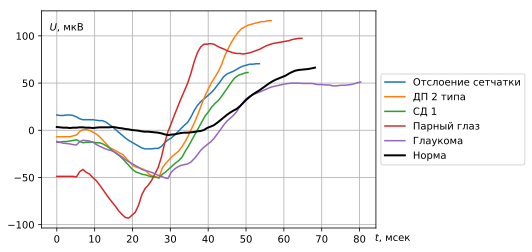

In [7]:
make_plot([data01, data02, data03, data05, data09, data16], 
          [u'Отслоение сетчатки', u'ДП 2 типа', u'СД 1', u'Парный глаз', u'Глаукома', u'Норма'])

Графики ЭРГ со схожими диагнозами (глаукома) и нормой для сравнения:

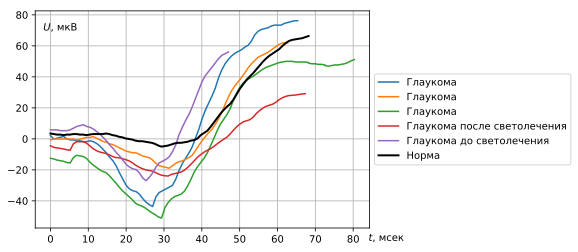

In [8]:
make_plot([data07, data08, data09, data10, data14, data16], 
          [u'Глаукома', u'Глаукома', u'Глаукома',
           u'Глаукома после светолечения',
           u'Глаукома до светолечения', u'Норма'])

## Предварительный анализ

ЭРГ схожих и различных диагнозов визуально имеют отчетливые сходства и различия - хотя бы в амплитуде сигнала. Поэтому в целях диагностики по изменению уровня амплитуды область значений сигналов можно разграничить, например, следующим образом:

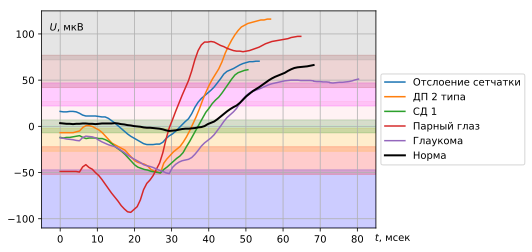

In [9]:
fig, ax = plt.subplots()

make_plot([data01, data02, data03, data05, data09, data16], 
          [u'Отслоение сетчатки', u'ДП 2 типа', u'СД 1', u'Парный глаз', u'Глаукома', u'Норма'], ax=ax)

alpha = 0.2
ax.add_patch(patches.Rectangle((-5, -110), 90, -47+110, alpha=alpha, color='blue'))
ax.add_patch(patches.Rectangle((-5, -52), 90, -22+52, alpha=alpha, color='red'))
ax.add_patch(patches.Rectangle((-5, -27), 90, -2+27, alpha=alpha, color='orange'))
ax.add_patch(patches.Rectangle((-5, -7), 90, 7+7, alpha=alpha, color='green'))
ax.add_patch(patches.Rectangle((-5, 2), 90, 27-2, alpha=alpha, color='pink'))
ax.add_patch(patches.Rectangle((-5, 22), 90, 47-22, alpha=alpha, color='magenta'))
ax.add_patch(patches.Rectangle((-5, 42), 90, 77-42, alpha=alpha, color='brown'))
ax.add_patch(patches.Rectangle((-5, 72), 90, 125-72, alpha=alpha, color='grey'))

plt.xlim([-5, 85])
plt.ylim([-110, 125])
plt.show()

Поскольку в данном исследовании классификатором выбрана нечеткая модель, для качественного (категориального) описания каждой зоны задается отдельная функция принадлежности. Все функции принадлежности здесь трапециевидные - хотя способ их аналитического задания не настолько важен, как их количество, области определения и форма:

In [10]:
def mf_left(k, gamma=1, t=(-1, 0)):
    if k < t[0]:
        return 1.
    elif k > t[1]:
        return 0.
    else:
        return abs( ((float(k) - t[1]) / (t[0] - t[1])) ** gamma )
    
def mf_centre(k, gamma_left=1, gamma_right=1, t=(-1, 0, 0, 1)):
    if k < t[0] or k > t[3]:
        return 0.
    elif t[0] <= k <= t[1]:
        return abs( ((float(k) - t[0]) / (t[1] - t[0])) ** gamma_left  )       
    elif t[2] <= k <= t[3]:
        return abs( ((float(k) - t[3]) / (t[2] - t[3])) ** gamma_right  )    
    else:
        return 1.
    
def mf_right(k, gamma=1, t=(0, 1)):
    if k > t[1]:
        return 1.
    elif k < t[0]:
        return 0.
    else:        
        return abs( ((float(k) - t[0]) / (t[1] - t[0])) ** gamma )

In [11]:
fv = {u'(-inf, -50]': lambda k: mf_left(k, t=(-52, -47)),
      u'[-50, -25]': lambda k: mf_centre(k, t=(-52, -47, -27, -22)),
      u'[-25, -5]': lambda k: mf_centre(k, t=(-27, -22, -7, -2)),
      u'[-5, 5]': lambda k: mf_centre(k, t=(-7, -2, 2, 7)),
      u'[5, 25]': lambda k: mf_centre(k, t=(2, 7, 22, 27)),
      u'[25, 45]': lambda k: mf_centre(k, t=(22, 27, 42, 47)),
      u'[45, 75]': lambda k: mf_centre(k, t=(42, 47, 72, 77)),
      u'[75, inf)': lambda k: mf_right(k, t=(72, 77))}

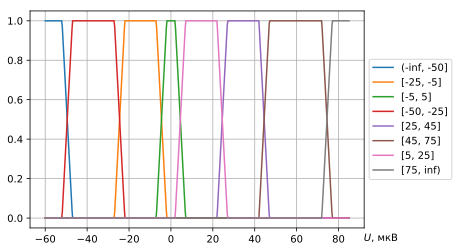

In [12]:
fig, ax = plt.subplots()

space = pd.Series(np.linspace(-60, 85, 500))
for term in sorted(fv.keys()):
    plt.plot(space, space.apply(fv[term]), label=term)
    
plt.grid(True)
plt.xlabel(u'$U$, мкВ')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_label_coords(1.05, -0.025)

## Подготовка выборки

Предлагается определять наличие признаков каждого из заболеваний поиском на ЭРГ характерных для них участков или шаблонов (patterns). Таком образом, задачу диагностики можно переформулировать в задачу классификации этих участков или шаблонов - причем многоклассовой классификации.

Для предобработки данных по временному ряду ЭРГ последовательно проходит скользящее окно (sliding window) заданной ширины *window_size* и собирает все возможные участки. Например, при ширине окна, равной 2, из ряда длиной *l* u[1], u[2], u[3]... u[*l*-1], u[*l*] будет образован массив участков вида {u[1], u[2]; u[2], u[3]... u[*l*-1], u[*l*]}. Данный массив уже можно рассматривать как матрицу "объекты-признаки" для задачи классификации - она будет размерностью *l*-*window_size*+1 объектов на *window_size* признаков. Если каждому объекту-участку поставить в соответствие код поставленного по ЭРГ диагноза, то получится и целевой вектор длиной *l*-*window_size*+1.

Для предотвращения дисбаланса классов в обучающей выборке:
* временные ряды должны быть примерно одинаковой длины и одинаковой частоты дискретизации,
* количество временных рядов по каждому из классов должно быть тоже одинаковым.

В качестве признаков можно рассмотреть не только уровни амплитуды сигнала u(t) на участке, но также последовательные сессии из них, уровни u'(t), u''(t) и разные синтезированные признаки (например, временные показатели, значения скользящего среднего и т.п.), однако в связи с риском переобучения на количество признаков и ширину окна *window_size* накладываются определенные ограничения, о чем будет сказано далее.

Подобная методика анализа временных рядов скользящим окном на практике является вполне рабочей альтернативой методам идентификации, параметрической оценки и моделирования - особенно в случаях, когда это затруднительно. Её можно применять в режиме online, offline и для отдельных частей временного ряда.

Результат такой предобработки ЭРГ (по одному примеру от каждого диагноза) с шириной окна, равной около 5 миллисекунд, частично приводится ниже.

In [13]:
def prepare_data(u, target=None, window_size=5):
    columns = ['u{}'.format(i + 1) for i in range(window_size)]
    
    df = pd.DataFrame(columns=columns)
    for i in range(u.shape[0] - window_size + 1):
        df.loc[i] = u.iloc[i : i + window_size].values
        
    if target:
        df.loc[:, 'target'] = target
        
    return df

In [14]:
window_size = 6 # 5

In [15]:
train = pd.concat([prepare_data(data01.u, 1, window_size),
                   prepare_data(data02.u, 2, window_size),
                   prepare_data(data03.u, 3, window_size),
                   prepare_data(data05.u, 5, window_size),
                   prepare_data(data09.u, 9, window_size),
                   prepare_data(data16.u, 16, window_size)], axis=0, ignore_index=True)

train.head()

,u1,u2,u3,u4,u5,u6,target
0,16.179402,15.681063,15.681063,16.179402,16.179402,15.681063,1
1,15.681063,15.681063,16.179402,16.179402,15.681063,14.186047,1
2,15.681063,16.179402,16.179402,15.681063,14.186047,12.192691,1
3,16.179402,16.179402,15.681063,14.186047,12.192691,11.196013,1
4,16.179402,15.681063,14.186047,12.192691,11.196013,11.196013,1


## Обучение модели

В начале обучения использующийся в исследовании нечеткий классификатор фаззифицирует участки ЭРГ из обучающей выборки, т.е. переводит уровни амлитуды сигнала из их количественных значений в качественное (категориальное) описание, которое с помощью функций принадлежности заранее дал специалист. При этом вся важная - согласно его описанию - динамика и факты смены уровня участков из обучающей выборки и подобных им сохранятся. Следует отметить, что фаззификация дает некоторую устойчивость к изменению значения сигнала (но сугубо в рамках заданной зоны).

Далее нечеткий классификатор рассматривает фаззифицированные значения признаков как подусловия нечеткого условия, объединенные логическим И (AND), а значения целевого вектора с кодами диагнозов - как нечеткое заключение в правиле вида:

<center>*if* **u1** *is* A *and* **u2** *is* B ... *then* **target** *is* Z</center>

В итоге собираются все правила с уникальными условиями, и при их объединении подсчитываются доли каждого из диагнозов как оценки их вероятности. Таким образом, из обучающей выборки формируется база правил нечеткой модели. Пример части правил из неё приведен ниже.

In [16]:
class GreyInterpreter:      
    
    def __init__(self, fvs, weighted=True, target_median=False, warning=False):
        self.fvs = fvs
        self.rules_info = None
        self.weighted = weighted
        self.rules_base = None
        self.proba_base = None
        self.feature_names = None
        self.target_name = None
        self.train_cs = None
        self.test_cs = None
        self.target_values = None
        self.target_median = target_median
        self.target_default = None
        self.warning = warning
        
        
    def make_fuzzy(self, info_line):    
        index = info_line[info_line != 0].index
        conclusion = pd.Series(index=index).fillna(0)
    
        for f in range(4): # 4: counts, max, median, mean
            stat = info_line[index].apply(lambda x: x[f])
            index = stat[stat == stat.max()].index
            if len(index) == 1:
                break
    
        conclusion[index[0]] = 1
    
        return conclusion
    
    
    def make_proba(self, info_line):    
        counts = info_line[info_line != 0].apply(lambda x: x[0])        
        probabilities = counts / np.sum(counts)
        return probabilities
        
    
    def fuzzyficate(self, X):
        df = pd.DataFrame(columns=self.feature_names)
        cs = [feature + '_c' for feature in self.feature_names]        
        
        for feature, fv in zip(self.feature_names, self.fvs):
            feature_terms = list(fv.keys())
            for term in feature_terms:
                df[term] = X[feature].apply(fv[term])
        
            df[feature + '_c'] = df[feature_terms].max(axis=1)
            df[feature] = df[feature_terms].idxmax(axis=1)
        
            df = df.drop(feature_terms, axis=1)
            
        df['c'] = df[cs].min(axis=1)
        df = df.drop(cs, axis=1)        
        
        return df
  
    
    def fit(self, X, y):
        self.feature_names = list(X.columns)
        self.target_name = y.name
        if self.target_median:
            self.target_default = int(y.median())    
            
        df = self.fuzzyficate(X)
        self.train_cs = df.c
    
        df = pd.concat([df, y], axis=1)
        self.rules_info = pd.pivot_table(df, values='c', index=self.feature_names, 
                                         columns=self.target_name, fill_value=0,
                                         aggfunc={'c': lambda s: [len(s), np.max(s),
                                                                  np.median(s), np.mean(s)]})    
        
        make_rm = self.make_fuzzy if self.weighted else self.make_proba
        self.rules_base = self.rules_info.apply(make_rm, axis=1).fillna(0)
        self.proba_base = self.rules_info.apply(self.make_proba, axis=1).fillna(0)
        self.target_values = self.rules_base.columns
        
        return HTML("GreyInterpreter(features={}, target='{}')".format(self.feature_names,
                                                                       self.target_name))
        
        
    def interfere(self, variables):
        interference = self.rules_base.reset_index()
        for feature, fv, var in zip(self.feature_names, self.fvs, variables):
            interference[feature] = interference[feature].apply(lambda term: fv[term](var))
        
        interference['_act'] = interference[self.feature_names].min(axis=1)
        
        for value in self.target_values:
            interference[value] = interference[[value, '_act']].min(axis=1)
            
        accumulation = interference[self.target_values].max(axis=0)
        
        return accumulation
    
    
    def predict_fuzzy(self, X):
        if np.array(X).size == len(self.feature_names):
            return self.interfere(X)
        return X.apply(self.interfere, axis=1)
    
    
    def add_rule(self, rule_dict, inplace=False):
        rule_df = pd.DataFrame.from_dict(rule_dict, orient='index')
        rules_base_edited = pd.concat([self.rules_base, rule_df], axis=0)
        
        if inplace:
            self.rules_base = rules_base_edited
        else:
            return rules_base_edited      
        
    
    def find_rule(self, condition, base):
        try:
            return base.loc[tuple(condition)] #.idxmax(axis=1)
        except:
            if self.warning:
                print('{}\n'.format(condition))
            return pd.Series(index=self.target_values).fillna(0.)
        
       
    def describe(self, X, proba=False):
        base = self.proba_base if proba else self.rules_base
                
        df = self.fuzzyficate(X)
        self.test_cs = df.c
        
        description = df[self.feature_names].apply( \
                         lambda condition: self.find_rule(condition, base), axis=1)
        
        return description
    
    
    def predict_proba(self, X):
        prediction_proba = self.describe(X, proba=True)        
        return prediction_proba
        
        
    def predict(self, X):
        description = self.describe(X)
        prediction = description.apply(lambda x: x.idxmax(axis=1) \
                                       if np.max(x) != 0 else self.target_default,
                                       axis=1)        
        return prediction
    

In [17]:
fvs = np.repeat(fv, window_size)

In [18]:
grey_clf = GreyInterpreter(fvs, weighted=True)

# set_target_default
grey_clf.target_default = -1

In [19]:
grey_clf.fit(train.iloc[:, :-1], train.target)

In [20]:
grey_clf.rules_base.head(14).astype(np.int64)

target                                                                   1   \
u1          u2          u3          u4          u5          u6                
(-inf, -50] (-inf, -50] (-inf, -50] (-inf, -50] (-inf, -50] (-inf, -50]   0   
                                                            [-50, -25]    0   
                                                [-50, -25]  [-50, -25]    0   
                                    [-50, -25]  [-50, -25]  [-50, -25]    0   
                        [-50, -25]  [-50, -25]  [-50, -25]  [-25, -5]     0   
                                                            [-50, -25]    0   
            [-50, -25]  [-50, -25]  [-50, -25]  [-25, -5]   [-5, 5]       0   
                                                [-50, -25]  [-50, -25]    0   
[-25, -5]   [-25, -5]   [-25, -5]   [-25, -5]   [-25, -5]   [-25, -5]     0   
                                                            [-5, 5]       1   
                                                            [-50, -25]    0   
                                                [-5, 5]     [-5, 5]       1   
                                                            [5, 25]       0   
                                                [-50, -25]  [-50, -25]    0   

target                                                                   2   \
u1          u2          u3          u4          u5          u6                
(-inf, -50] (-inf, -50] (-inf, -50] (-inf, -50] (-inf, -50] (-inf, -50]   0   
                                                            [-50, -25]    0   
                                                [-50, -25]  [-50, -25]    0   
                                    [-50, -25]  [-50, -25]  [-50, -25]    0   
                        [-50, -25]  [-50, -25]  [-50, -25]  [-25, -5]     0   
                                                            [-50, -25]    0   
            [-50, -25]  [-50, -25]  [-50, -25]  [-25, -5]   [-5, 5]       0   
                                                [-50, -25]  [-50, -25]    0   
[-25, -5]   [-25, -5]   [-25, -5]   [-25, -5]   [-25, -5]   [-25, -5]     0   
                                                            [-5, 5]       0   
                                                            [-50, -25]    0   
                                                [-5, 5]     [-5, 5]       0   
                                                            [5, 25]       1   
                                                [-50, -25]  [-50, -25]    0   

target                                                                   3   \
u1          u2          u3          u4          u5          u6                
(-inf, -50] (-inf, -50] (-inf, -50] (-inf, -50] (-inf, -50] (-inf, -50]   0   
                                                            [-50, -25]    0   
                                                [-50, -25]  [-50, -25]    0   
                                    [-50, -25]  [-50, -25]  [-50, -25]    0   
                        [-50, -25]  [-50, -25]  [-50, -25]  [-25, -5]     0   
                                                            [-50, -25]    0   
            [-50, -25]  [-50, -25]  [-50, -25]  [-25, -5]   [-5, 5]       0   
                                                [-50, -25]  [-50, -25]    0   
[-25, -5]   [-25, -5]   [-25, -5]   [-25, -5]   [-25, -5]   [-25, -5]     0   
                                                            [-5, 5]       0   
                                                            [-50, -25]    0   
                                                [-5, 5]     [-5, 5]       0   
                                                            [5, 25]       0   
                                                [-50, -25]  [-50, -25]    0   

target                                                                   5   \
u1          u2          u3          u4          u5          u6                
(-inf, -50] (-inf, -50] (-inf, -50] (-inf, -50]

## Проверка работы модели

Тестовая ЭРГ перед обращением к нечеткому классификатору должна быть обработана точно так же, как и обучающие.

Нечеткий классификатор фаззифицирует участки ЭРГ и выдает по всем полученным таким образом нечетким условиям наиболее выроятный диагноз - если нечеткое заключение для правила есть в базе. В противном случае можно либо не ставить диагноз, пропуская данный учвсток, либо ставить, например, медианный или чаще всего встречавшийся в целевом векторе диагноз. При правильно подобранном количестве и составе нечетких подусловий таких участков в тестовой выборке должно быть мало, и на общий результат они сильно не повлияют.

Наиболее вероятные диагнозы по всем участкам тестовой ЭРГ собираются в вектор предсказаний. Вектор предсказаний для итоговой диагностики наличия заболеваний можно обрабатывать следующими способами:
* подсчитать доли диагнозов и утвердить как окончательный наиболее вероятный или достигший нужного уровня значимости диагноз (можно полнее задействовать здесь статистический аппарат);
* использовать его, например, для визуализации соответствующих участков ЭРГ;
* передать его на дальнейший узел системы диагностики (например, если классификаторов несколько).

В качестве иллюстраций первого и второго подходов ниже приводятся вероятностные оценки и визуализация участков ЭРГ некоторых дагнозов:

In [21]:
diagnosis_dict = {1: u'Отслоение сетчатки',
                  2: u'ДП 2 типа',
                  3: u'СД 1',
                  5: u'Парный глаз',
                  9: u'Глаукома',
                  16: u'Норма',
                 -1: u'Нет диагноза'}

In [22]:
def make_diagnosis(grey_clf, data):
    prepared_data = prepare_data(data.u, window_size=window_size)
    
    pred = grey_clf.predict(prepared_data)
    pred_proba = grey_clf.predict_proba(prepared_data)
    pred_fuzzy = grey_clf.predict_fuzzy(prepared_data)
    
    diagnoses = pred.value_counts(normalize=True)
    probabilities = pred_proba.mean(axis=0).sort_values(ascending=False)
    fuzzy_diagnoses = pred_fuzzy.mean(axis=0).sort_values(ascending=False)
    
    df = pd.DataFrame.from_dict({u'Диагноз': diagnosis_dict}, orient='columns')
    df.loc[diagnoses.index, u'Итог:'] = diagnoses
    df.loc[probabilities.index, u'Вероятный:'] = probabilities
    df.loc[fuzzy_diagnoses.index, u'Нечеткий:'] = fuzzy_diagnoses
    df = df.sort_values(by=u'Вероятный:', ascending=False).fillna(u'-')
    
    fig, ax = plt.subplots()
    
    for diagnosis in diagnoses.index:
        index = pred[pred == diagnosis].index
        plt.scatter(data.t[index], data.u[index],
                    label=diagnosis_dict[diagnosis], marker='s')  
        
    plt.grid(True)
    plt.xlabel(u'$t$, мсек')
    plt.ylabel(u'$U$, мкВ', rotation=0)
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_label_coords(1.05, -0.025)
    ax.yaxis.set_label_coords(0.075, 0.9)
    
    return df

,Диагноз,Итог:,Вероятный:,Нечеткий:
1,Отслоение сетчатки,0.551724,0.455944,0.475576
9,Глаукома,0.37931,0.231964,0.370168
16,Норма,0.0172414,0.127985,0.0262229
3,СД 1,0.0517241,0.118309,0.0455722
2,ДП 2 типа,-,0.0629244,0.0209417
5,Парный глаз,-,0.00287356,0
-1,Нет диагноза,-,-,-


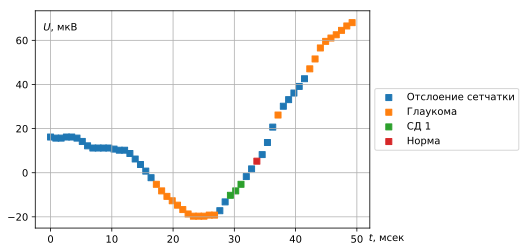

In [23]:
make_diagnosis(grey_clf, data01)

,Диагноз,Итог:,Вероятный:,Нечеткий:
2,ДП 2 типа,0.311475,0.440539,0.240954
5,Парный глаз,0.213115,0.202359,0.200715
9,Глаукома,0.295082,0.137373,0.254188
3,СД 1,0.0491803,0.105151,0.061997
1,Отслоение сетчатки,0.114754,0.0598297,0.0941282
16,Норма,0.0163934,0.0547482,0.0234277
-1,Нет диагноза,-,-,-


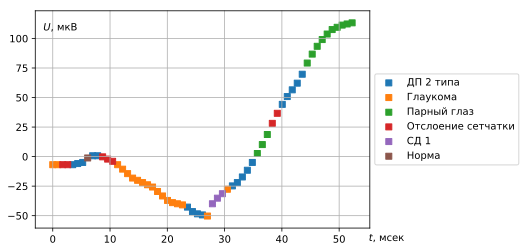

In [24]:
make_diagnosis(grey_clf, data02)

,Диагноз,Итог:,Вероятный:,Нечеткий:
5,Парный глаз,0.816901,0.745639,0.796645
2,ДП 2 типа,0.056338,0.173858,0.086824
9,Глаукома,0.112676,0.0428749,0.0660193
3,СД 1,-,0.0329329,0.00597029
1,Отслоение сетчатки,0.0140845,0.00234742,0.00811421
16,Норма,-,0.00234742,0
-1,Нет диагноза,-,-,-


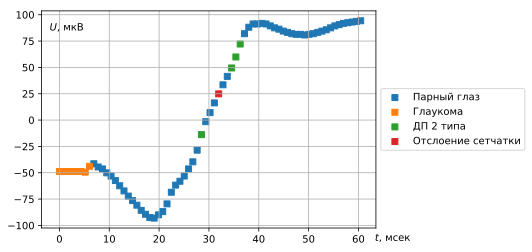

In [25]:
make_diagnosis(grey_clf, data05)

,Диагноз,Итог:,Вероятный:,Нечеткий:
9,Глаукома,0.55914,0.27924,0.564712
16,Норма,0.139785,0.244363,0.131115
1,Отслоение сетчатки,0.193548,0.209564,0.194488
3,СД 1,-,0.116361,0.00300023
2,ДП 2 типа,0.0430108,0.0841632,0.0410783
5,Парный глаз,-,0.00179211,0
-1,Нет диагноза,0.0645161,-,-


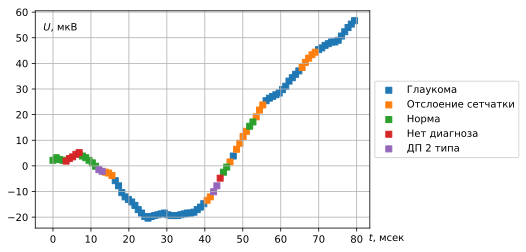

In [26]:
make_diagnosis(grey_clf, data11)

,Диагноз,Итог:,Вероятный:,Нечеткий:
16,Норма,0.586667,0.675608,0.481112
9,Глаукома,0.2,0.147247,0.236843
1,Отслоение сетчатки,0.16,0.0989751,0.211731
2,ДП 2 типа,0.0533333,0.0445285,0.0719152
3,СД 1,-,0.0314195,0
5,Парный глаз,-,0.00222222,0
-1,Нет диагноза,-,-,-


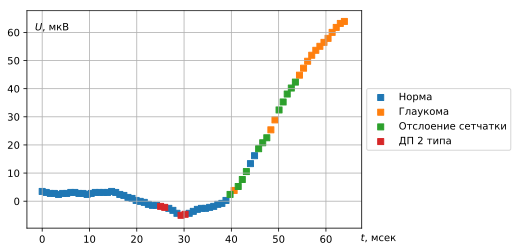

In [27]:
make_diagnosis(grey_clf, data16)

## Оценка качества работы модели

Метрикой качества работы нечеткого классификатора можно выбрать долю совпадений (accuracy) между кодами наиболее вероятных диагнозов, которые дал классификатор, и исходными кодами.

Метрика accuracy рассматриваемого классификатора при его работе со всеми имеющимися ЭРГ:

In [28]:
pred_classes = []

for data in all_data:
    pred = grey_clf.predict(prepare_data(data.u, window_size=window_size))
    pred_classes.append(pred.value_counts(normalize=True).index[0])
    
accuracy_score(true_classes, pred_classes)

0.8571428571428571

Доля правильных ответов классификатора составила 12 из 14.

Ошибки произошли на следующих ЭРГ:

In [29]:
res = pd.DataFrame({'pred': pred_classes, 'true': true_classes},
                   index=file_names, columns=['true', 'pred'])

res.loc[res.pred != res.true]

,true,pred
14.xls,9,1
3.xls,3,9


* глаукома до светолечения диагностирована как отслоение сетчатки;

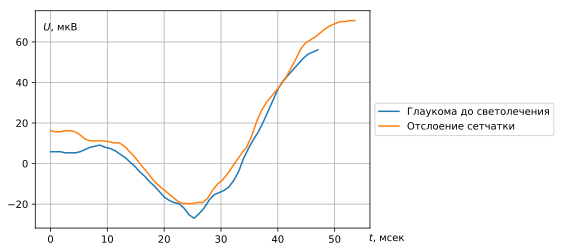

In [30]:
make_plot([data14, data01], [u'Глаукома до светолечения', u'Отслоение сетчатки'])

* патология СД 1 определена как глаукома.

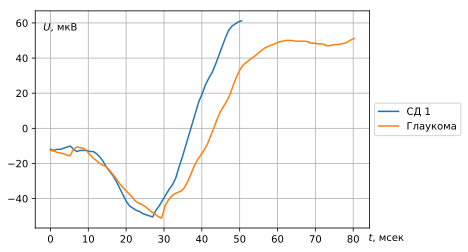

In [31]:
make_plot([data03, data09], [u'СД 1', u'Глаукома'])

Видна существенная схожесть каждой пары данных ЭРГ; и для более точной диагностики здесь требуются более глубокие и подробные исследования.

В наборе имеющихся ЭРГ следует отметить дисбаланс в виде преобладания глауком - тогда как метрика accuracy при дисбалансе классов зачастую работает некорректно. В таком случае метрика accuracy обученного классификатора сравнивается с метрикой константного классификатора, который все относит к наиболее популярному классу.

In [32]:
constant_prediction = np.repeat(9, len(all_data))

accuracy_score(true_classes, constant_prediction)

0.6428571428571429

Доля правильных ответов искусственного константного классификатора составила 9 из 14. Это худшее значение метрики accuracy, полученное в данном исследовании. При ином результате потребовалось бы сменить метрику.

## Выбор ширины окна

Ширина скользящего окна *window_size* сама по себе является важным гиперпараметром, значение которого правильно выбрать оптимально, но в данном случае она также напрямую определеляет размерность и состав базы правил.

Ниже для нечеткого классификатора, обученного на ширине окна от 1 до 15 миллисекунд, находятся зависимости от значений *window_size*:
* количества правил в базе правил,
* метрики accuracy по всем 14 ЭРГ,
* среднего и СКО вероятностей поставленных по всем ЭРГ диагнозам (*p* max).

Обучаются два варианта классификатора - вероятностный и взвешенный.

In [33]:
window_sizes = np.arange(1, 16)

rules_count, accuracies = [], []
rules_count_weighted, accuracies_weighted = [], []

p_mean, p_std = [], []
p_mean_weighted, p_std_weighted = [], []

print('№: {}\n'.format(np.array(true_classes, dtype=np.int64)))

for window_size in window_sizes:
    train = pd.concat([prepare_data(data01.u, 1, window_size),
                       prepare_data(data02.u, 2, window_size),
                       prepare_data(data03.u, 3, window_size),
                       prepare_data(data05.u, 5, window_size),
                       prepare_data(data09.u, 9, window_size),
                       prepare_data(data16.u, 16, window_size)], axis=0, ignore_index=True)     
    fvs = np.repeat(fv, window_size)
    
    grey_clf = GreyInterpreter(fvs, weighted=False)
    grey_clf_weighted = GreyInterpreter(fvs)
    
    grey_clf.fit(train.iloc[:, :-1], train.target)
    grey_clf_weighted.fit(train.iloc[:, :-1], train.target)
    
    rules_count.append(grey_clf.rules_info.shape[0])
    rules_count_weighted.append(grey_clf_weighted.rules_info.shape[0])
    
    pred_classes, p_max = [], []
    pred_classes_weighted, p_max_weighted = [], []
    
    for data in all_data:
        pred = grey_clf.predict(prepare_data(data.u, window_size=window_size))
        pred_weighted = grey_clf_weighted.predict(prepare_data(data.u, window_size=window_size))
        
        pred_classes.append(pred.value_counts(normalize=True).index[0])
        pred_classes_weighted.append(pred_weighted.value_counts(normalize=True).index[0])
        
        p_max.append(pred.value_counts(normalize=True).iloc[0])
        p_max_weighted.append(pred_weighted.value_counts(normalize=True).iloc[0])
    
    accuracies.append(accuracy_score(true_classes, pred_classes))
    accuracies_weighted.append(accuracy_score(true_classes, pred_classes_weighted))

    p_mean.append(np.mean(p_max))
    p_mean_weighted.append(np.mean(p_max_weighted))
    
    p_std.append(np.std(p_max, ddof=1))
    p_std_weighted.append(np.std(p_max_weighted, ddof=1))
    
    print('{}: {}'.format(window_size, np.array(pred_classes_weighted, dtype=np.int64)))

№: [ 1  9  9  9  9  9  9 16  2  3  5  9  9  9]

1: [ 9  9  9  9  9  9  9 16  9  9  5  9  9  9]
2: [ 9  9  9  9  9  9  9 16  9  9  5  9  9  9]
3: [ 9  9  9  9  9  9  9 16  9  9  5  9  9  9]
4: [ 9  9  9  9  9  1  9 16  9  9  5  9  9  9]
5: [ 1  9  9  9  9  1  9 16  9  9  5  9  9  9]
6: [ 1  9  9  9  9  1  9 16  2  9  5  9  9  9]
7: [ 1  9  9  9  9  1  9 16  2  9  5  9  9  9]
8: [ 1  9  9  9  9  1  9 16  2  9  5  9  9  9]
9: [ 1  9  9  9  9  1  9 16  2  9  5  9  9  9]
10: [ 1  9  9  9  9  1  9 16  2  9  5  9  9  9]
11: [ 1  9  9  9  9  1  9 16  2  9  5  9  9  9]
12: [ 1  9  9  9  9  1  9 16  2  9  5  9  9  9]
13: [ 1  9  9  9  9  1  9 16  2  9  5  9  9  9]
14: [ 1  9  9  9  9  1  9 16  2  9  5  9  1  9]
15: [ 1  9  9  9  9  1  9 16  2  9  5  9  1  9]


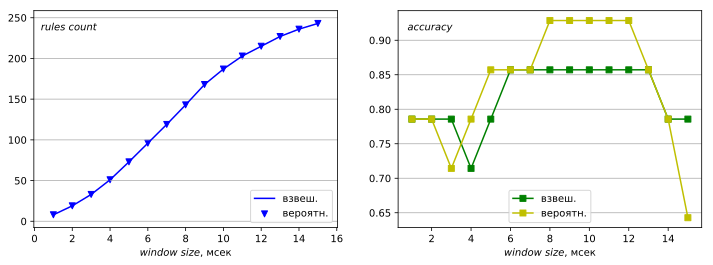

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()

ax1.plot(window_sizes, rules_count_weighted, c='b', label=u'взвеш.')
ax1.scatter(window_sizes, rules_count, c='b', marker='v', label=u'вероятн.')
ax1.legend(loc='lower right')
ax1.grid(True, axis='y')
ax1.set_xlabel(u'$window$ $size$, мсек')
ax1.set_ylabel(u'$rules$ $count$', rotation=0)    
ax1.yaxis.set_label_coords(0.115, 0.9)

ax2.plot(window_sizes, accuracies_weighted, c='g', marker='s', label=u'взвеш.')
ax2.plot(window_sizes, accuracies, c='y', marker='s', label=u'вероятн.')
ax2.legend(loc='lower center')
ax2.grid(True, axis='y')
ax2.set_xlabel(u'$window$ $size$, мсек')
ax2.set_ylabel(u'$accuracy$', rotation=0)
ax2.yaxis.set_label_coords(0.105, 0.9)

fig.set_size_inches(12, 4)

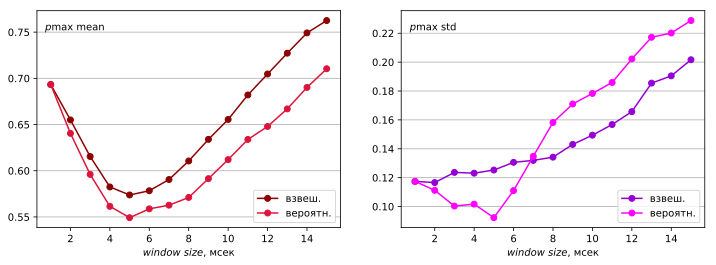

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()

ax1.plot(window_sizes, p_mean_weighted, c='darkred', marker='o', label=u'взвеш.')
ax1.plot(window_sizes, p_mean, c='crimson', marker='o', label=u'вероятн.')
ax1.legend(loc='lower right')
ax1.grid(True, axis='y')
ax1.set_xlabel(u'$window$ $size$, мсек')
ax1.set_ylabel(u'$p$max mean', rotation=0)    
ax1.yaxis.set_label_coords(0.125, 0.9)

ax2.plot(window_sizes, p_std_weighted, c='darkviolet', marker='o', label=u'взвеш.')
ax2.plot(window_sizes, p_std, c='magenta', marker='o', label=u'вероятн.')
ax2.legend(loc='lower right')
ax2.grid(True, axis='y')
ax2.set_xlabel(u'$window$ $size$, мсек')
ax2.set_ylabel(u'$p$max std', rotation=0)    
ax2.yaxis.set_label_coords(0.105, 0.9)

fig.set_size_inches(12, 4)

Увеличение *window_size* вызывает увеличение и количества правил в базе нечеткого классификатора из-за увеличения количества подусловий и их возможных комбинаций в нечетких условиях.

Увеличение количества подусловий в правилах подразумевает, что правила становятся более конкретными, более прецедентными и в каком-то роде менее робастными - т.е. подходят для все меньшего количества участков ЭРГ. Таким образом, обобщающая способность нечеткого классификатора падает, и возникает риск переобучения.

Из-за переобучения становятся:
* меньше доля правильных итоговых диагнозов;
* больше средние *p* max и больше разброс их значений (т.е. идет большее подстраивание под некоторые ЭРГ из обучающего набора).

Все большее количество участков других ЭРГ с таким же диагнозом с увеличением *window_size* не подходят под правила для него, все меньше в ЭРГ содержится (или не содержится вообще) необходимых участков. Отсюда больше кодов неверных диагнозов в предсказаниях классификатора, и в итоге меньше доля правильно определенных диагнозов.

Взвешенность, т.е. больший учет характерных участков, хорошо повлияла на недообучение при малых *window_size* и на риск переобучения при больших. Оптимальные значения для вероятностного классификаторе *window_size* = 5, для взвешенного – *window_size* = 6. Со взвешенностью наблюдается сброс доли правильных диагнозов, но при этом нет худшего ее значения. Кроме того, стали:
* больше средние *p* max;
* но меньше и уже разброс их значений.

Подбирать ширину окна в данном случае (и количество подусловий в общем) необходимо так, чтобы были:
* хорошие значения метрики качества классификации;
* не слишком высокое значение среднего *p* max при их низком СКО - т.е. чтобы было стабильно на всех примерах.

По смыслу уменьшение избыточного количества нечетких подусловий перекликается с ограничением глубины решающего дерева, кусочно-линейной функции, также реализующей логические правила - тоже из-за риска переобучения.
 
Поэтому для данной задачи требуется тщательная и вдумчивая работа при подготовке информации:
1. Для обучающей и тестовой выборок необходимо иметь больше ЭРГ всех диагнозов самого разнообразного по всем диагнозам вида.
2. Правила диагностики должны быть подробными, определяющими и достаточными - что можно сформулировать как задачи выбора признаков и их описания в виде состава и формы их функций принадлежности.
3. Как показывает практика, в решении сложных задач машинного обучения самый удачный результат обычно получается при использовании композиций методов: суперпозиций, бустингов, нейронных сетей и т.д. Для более точной диагностики стоит рассмотреть и композиции нечетких моделей.